<br>
<br>
<br>
<center><big><b>Hist-unmix</center></big><br></b>
<center><b>Hi!</b> Welcome to <i>Hist-unmix</i>, a python package to separate susceptibility components of distorted magnetic hysteresis!<br></center>
<br>
<hr>
&ensp;<b>1.</b> Before running the cells, make sure all of the extensions are corrected installed in your machine<i> (check the READ_ME_1 file);</i><br>
&ensp;<b>2.</b> Make sure your file is included in the same directory holding <i>Hist-unmix</i>;<br>
&ensp;<b>3.</b> Individually run each code cell by firstly clicking on a cell and sequentially clicking on the <i>Run</i> button (or press <i> Shift+Enter</i>);<br>
&ensp;<b>4.</b> Unless you are an advanced python-user, avoid modifications on the code.<br>
&ensp;<b>5.</b> We recommend cleaning the kernel before running a new sample. Go to the Kernel tab and click on <i>"Restart & Clear Output"</i>;<br>
&ensp;<b>6.</b> Images and csv-files from this package will be saved in the same directory.
<hr>
<br>



<br>
<br>
<br>
<hr>
<center><b><big>1. INITIALIZATION</center></b></big>
<hr>
<br>
<br>
<br>

In [1]:
%matplotlib notebook
import pandas as pd
import math
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import plotly.graph_objects as go
from Hist_functions import GGCD_1C,GGCD_2C,GGCD_3C,ferro_area,rev_ferro_area
from Hist_functions import region_selection,line_inv,moving_mean,gradient,high_field,R2_calc
from Hist_functions import Levenberg_Marquardt_1C,Levenberg_Marquardt_2C,Levenberg_Marquardt_3C,Levenberg_Marquardt_HF
from IPython.display import display
from scipy.special import gamma
from scipy.integrate import simpson
from scipy import interpolate


plt.rcParams.update({'font.size': 10})

<br>
<br>
<br>
<hr>
<center><b><big>2. LOADING THE FILE</center></b></big>
<hr>
<br>
<br>
<br>

In [2]:
print('Please, use the button select your file! ')
print('Make sure your file has two columns, one for x (field, in Tesla) and other for y (magnetic momentum, Am²), delimited by a comma. ')

uploader = widgets.FileUpload()
display(uploader)


Please, use the button select your file! 
Make sure your file has two columns, one for x (field, in Tesla) and other for y (magnetic momentum, Am²), delimited by a comma. 


FileUpload(value={}, description='Upload')

In [3]:
file=uploader.metadata[0]['name']
sample=input('Name your sample! R: ')

Name your sample! R: Halelluiah


<br>
<br>
<br>
<hr>
<center><b><big>3. FILTERING</center></b></big>
<hr>
<br>
<br>
<br>

Enter the grouping value for a moving mean filter (must be an integer>1)! R: 5
How many rows should be skipped (must be an integer)? R: 1
Would you like to normalize by mass?(Y/N) R: N


<IPython.core.display.Javascript object>


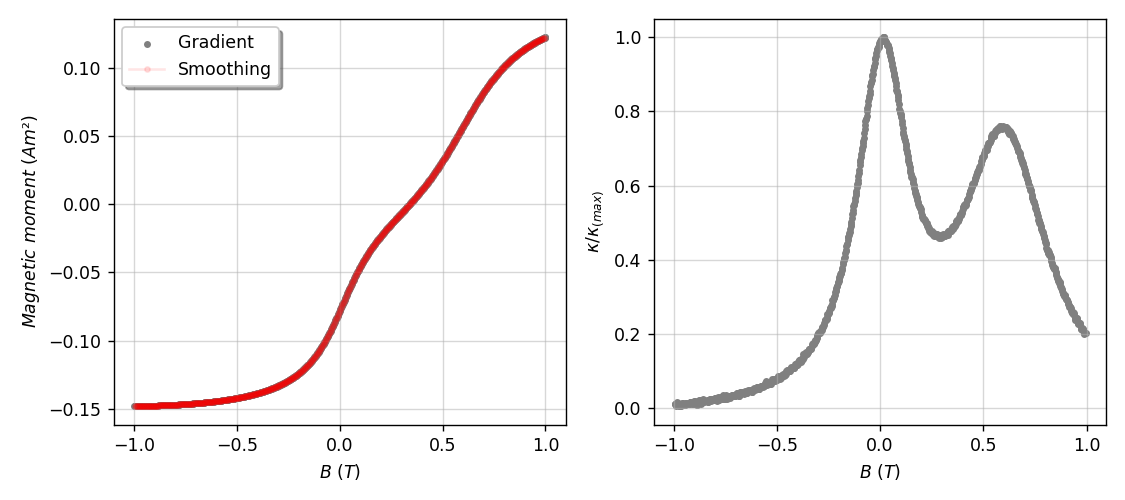

In [4]:
grouping = int(input("Enter the grouping value for a moving mean filter (must be an integer>1)! R: "))
rows=int(input("How many rows should be skipped (must be an integer)? R: "))

x,y=np.loadtxt(file,delimiter=',',unpack=True,skiprows=rows)

mass_norm=input('Would you like to normalize by mass?(Y/N) R: ')
if mass_norm=='Y':
    mass=float(input('Provide the mass (kg) R: '))
    y=y/mass
    
    xnew,ynew=moving_mean(x,grouping),moving_mean(y,grouping)

    grad_y=gradient(xnew,ynew)
    grad_original=np.copy(grad_y)


    factor=max(grad_y)
    grad_y=grad_y/factor
    figure,(ax1,ax2)=plt.subplots(1,2,figsize=(9,4))

    ax1.scatter(x,y,marker='.',c='gray',label='Gradient')
    ax1.plot(xnew,ynew,marker='.',c='r',alpha=0.1,label='Smoothing')
    ax1.legend(shadow=True)
    ax1.set_xlabel(r'$B \ (T)$')
    ax1.set_ylabel(r'$Magnetic \  moment \ (Am²/kg)$')
    ax1.grid(alpha=0.5)


    ax2.scatter(xnew,grad_y,marker='.',color='gray')
    ax2.set_xlabel(r'$B \ (T)$')
    ax2.set_ylabel(r'$\kappa / \kappa_{(max)}$')
    ax2.grid(alpha=0.5)
    figure.tight_layout()

    plt.savefig('Smoothing and First Derivative '+str(sample)+'.pdf',dpi=300,facecolor='w')

if mass_norm=='N':
    y=y
    
    xnew,ynew=moving_mean(x,grouping),moving_mean(y,grouping)

    grad_y=gradient(xnew,ynew)
    grad_original=np.copy(grad_y)


    factor=max(grad_y)
    grad_y=grad_y/factor
    figure,(ax1,ax2)=plt.subplots(1,2,figsize=(9,4))

    ax1.scatter(x,y,marker='.',c='gray',label='Gradient')
    ax1.plot(xnew,ynew,marker='.',c='r',alpha=0.1,label='Smoothing')
    ax1.legend(shadow=True)
    ax1.set_xlabel(r'$B \ (T)$')
    ax1.set_ylabel(r'$Magnetic \  moment \ (Am²)$')
    ax1.grid(alpha=0.5)


    ax2.scatter(xnew,grad_y,marker='.',color='gray')
    ax2.set_xlabel(r'$B \ (T)$')
    ax2.set_ylabel(r'$\kappa / \kappa_{(max)}$')
    ax2.grid(alpha=0.5)
    figure.tight_layout()

    plt.savefig('Smoothing and First Derivative '+str(sample)+'.pdf',dpi=300,facecolor='w')


<br>
<br>
<br>
<hr>
<center><b><big>4. FORWARD MODEL</center></b></big>
<hr>
<br>
<br>
<br>

&ensp;<b>A ↓</b> Estimate the scale of the ferromagnetic contribution:
<br>

In [5]:

guesses,slope=ferro_area(xnew,grad_y,ynew,region_selection,line_inv)
grad_ferro=grad_y-(slope/factor)


&ensp;<b>B↓</b> Adjust a forward model with 1, 2 or 3 susceptibility components:
<br>
<br>

In [10]:
def forward_model1(u1=0.001, theta1=0.1, alfa1=1,beta1=1,I1=guesses):
    
    f_term=(-np.log10((1/2)-((1/np.pi)*np.arctan((xnew-abs(u1))/abs(theta1)))))**(abs(alfa1)-1)
    s_term=((1/2)-((1/np.pi)*np.arctan((xnew-abs(u1))/abs(theta1))))**((1/abs(beta1))-1)
    t_term=((np.pi*abs(theta1)*(abs(beta1)**abs(alfa1))*gamma(abs(alfa1)))*(1+(((xnew-abs(u1))/abs(theta1))**2)))
    
    Y=(((f_term*s_term)/(t_term))*abs(I1))
    
    figure,(ax1)=plt.subplots(figsize=(5,5))
    ax1.plot(xnew,Y,label='Forward model',color='brown')
    ax1.scatter(xnew,grad_ferro,marker='.',label='Data',color='gray',alpha=0.5)
    ax1.set_xlabel(r'$B \ (T)$')
    ax1.set_ylabel(r'$\kappa / \kappa_{(max)} - \kappa_{0}$')
    ax1.set_title(f'{sample}')
    ax1.legend(shadow=True)
    ax1.grid(alpha=0.5)
    figure.tight_layout()
    plt.savefig('forward_ model '+str(sample)+'.pdf',dpi=300,facecolor='w')
    parameters=[u1,theta1,alfa1,beta1]
    return parameters


def forward_model2(u1=0.001, theta1=0.1, alfa1=1,beta1=1,I1=guesses,
                u2=0.3, theta2=0.4, alfa2=1,beta2=1,I2=guesses):
    
    f_term1=(-np.log10((1/2)-((1/np.pi)*np.arctan((xnew-abs(u1))/abs(theta1)))))**(abs(alfa1)-1)
    s_term1=((1/2)-((1/np.pi)*np.arctan((xnew-abs(u1))/abs(theta1))))**((1/abs(beta1))-1)
    t_term1=((np.pi*abs(theta1)*(abs(beta1)**abs(alfa1))*gamma(abs(alfa1)))*(1+(((xnew-abs(u1))/abs(theta1))**2)))

    f_term2=(-np.log10((1/2)-((1/np.pi)*np.arctan((xnew-abs(u2))/abs(theta2)))))**(abs(alfa2)-1)
    s_term2=((1/2)-((1/np.pi)*np.arctan((xnew-abs(u2))/abs(theta2))))**((1/abs(beta2))-1)
    t_term2=((np.pi*abs(theta2)*(abs(beta2)**abs(alfa2))*gamma(abs(alfa2)))*(1+(((xnew-abs(u2))/abs(theta2))**2)))
    
    y1=(((f_term1*s_term1)/(t_term1))*abs(I1))
    y2=(((f_term2*s_term2)/(t_term2))*abs(I2))

    Y=(y1+y2)
    
    figure,(ax1)=plt.subplots(figsize=(5,5))
    ax1.plot(xnew,Y,label='Forward model',color='brown')
    ax1.plot(xnew,y1,label=r'$C_{a}$',color='royalblue',linestyle='dashed')
    ax1.plot(xnew,y2,label=r'$C_{b}$',color='forestgreen',linestyle='dashed')
    ax1.scatter(xnew,grad_ferro,marker='.',label='Data',color='gray',alpha=0.5)
    ax1.set_xlabel(r'$B \ (T)$')
    ax1.set_ylabel(r'$\kappa / \kappa_{(max)} - \kappa_{0}$')
    ax1.set_title(f'{sample}')
    ax1.legend(shadow=True)
    ax1.grid(alpha=0.5)
    figure.tight_layout()
    plt.savefig('forward_ model '+str(sample)+'.pdf',dpi=300,facecolor='w')
    parameters=[u1,theta1,alfa1,beta1,u2,theta2,alfa2,beta2]
    return parameters


def forward_model3(u1=0.001, theta1=0.1, alfa1=1,beta1=1,I1=guesses,
                u2=0.3, theta2=0.4, alfa2=1,beta2=1,I2=guesses,
                u3=0.6, theta3=0.4, alfa3=1,beta3=1,I3=guesses):
    
    f_term1=(-np.log10((1/2)-((1/np.pi)*np.arctan((xnew-abs(u1))/abs(theta1)))))**(abs(alfa1)-1)
    s_term1=((1/2)-((1/np.pi)*np.arctan((xnew-abs(u1))/abs(theta1))))**((1/abs(beta1))-1)
    t_term1=((np.pi*abs(theta1)*(abs(beta1)**abs(alfa1))*gamma(abs(alfa1)))*(1+(((xnew-abs(u1))/abs(theta1))**2)))

    f_term2=(-np.log10((1/2)-((1/np.pi)*np.arctan((xnew-abs(u2))/abs(theta2)))))**(abs(alfa2)-1)
    s_term2=((1/2)-((1/np.pi)*np.arctan((xnew-abs(u2))/abs(theta2))))**((1/abs(beta2))-1)
    t_term2=((np.pi*abs(theta2)*(abs(beta2)**abs(alfa2))*gamma(abs(alfa2)))*(1+(((xnew-abs(u2))/abs(theta2))**2)))

    f_term3=(-np.log10((1/2)-((1/np.pi)*np.arctan((xnew-abs(u3))/abs(theta3)))))**(abs(alfa3)-1)
    s_term3=((1/2)-((1/np.pi)*np.arctan((xnew-abs(u3))/abs(theta3))))**((1/abs(beta3))-1)
    t_term3=((np.pi*abs(theta3)*(abs(beta3)**abs(alfa3))*gamma(abs(alfa3)))*(1+(((xnew-abs(u3))/abs(theta3))**2)))
    
    y1=(((f_term1*s_term1)/(t_term1))*abs(I1))
    y2=(((f_term2*s_term2)/(t_term2))*abs(I2))
    y3=(((f_term3*s_term3)/(t_term3))*abs(I3))

    Y=(y1+y2+y3)
    
    figure,(ax1)=plt.subplots(figsize=(5,5))
    ax1.plot(xnew,Y,label='Forward model',color='brown')
    ax1.plot(xnew,y1,label=r'$C_{a}$',color='royalblue',linestyle='dashed')
    ax1.plot(xnew,y2,label=r'$C_{b}$',color='forestgreen',linestyle='dashed')
    ax1.plot(xnew,y3,label=r'$C_{c}$',color='m',linestyle='dashed')
    ax1.scatter(xnew,grad_ferro,marker='.',label='Data',color='gray',alpha=0.5)
    ax1.set_xlabel(r'$Applied field \ (T)$')
    ax1.set_ylabel(r'$\kappa / \kappa_{(max)} - \kappa_{0}$')
    ax1.set_title(f'{sample}')
    ax1.legend(shadow=True)
    ax1.grid(alpha=0.5)
    figure.tight_layout()
    plt.savefig('forward_ model '+str(sample)+'.pdf',dpi=300,facecolor='w')
    parameters=[u1,theta1,alfa1,beta1,u2,theta2,alfa2,beta2,u3,theta3,alfa3,beta3]
    return parameters

Choice1=input(('How many components would you like to adjust? R: '))

if Choice1=='1':
    ajust=forward_model1
if Choice1=='2':
    ajust=forward_model2
if Choice1=='3':
    ajust=forward_model3




a=widgets.interactive(ajust,u1=(0,2,0.0001),
                      theta1=(0,1,0.01),alfa1=(0.01,10,0.01),beta1=(0.01,10,0.01),I1=(0,guesses+(2.5*guesses),0.0001),
                      u2=(0,2,0.0001),theta2=(0,1,0.01),alfa2=(0.01,10,0.01),beta2=(0.01,10,0.01),I2=(0,guesses+(2.5*guesses),0.0001),
                      u3=(0,2,0.0001),theta3=(0,1,0.01),alfa3=(0.01,10,0.01),beta3=(0.01,10,0.01),I3=(0,guesses+(2.5*guesses),0.0001));
display(a)



How many components would you like to adjust? R: 2


interactive(children=(FloatSlider(value=0.001, description='u1', max=2.0, step=0.0001), FloatSlider(value=0.1,…

<br>
<br>
<br>
<hr>
<center><b><big>5. INVERSE MODEL</center></b></big>
<hr>
<br>
<br>
<br>

&ensp;<b>A ↓</b> Set the initial guesses for optimization <i>($\chi_{0}$,$\mu$,$\sigma$,$\alpha$,$\beta$,$I$)</i>:
<br>

In [17]:

constrain=input('Would you like to constrain the solutions assuming that u(mean) is a constant?(Y/N) R: ')
print(' ')
Option=[]
if constrain=='Y':
    if Choice1=='2':
        Option=input('Type A to restrict the first, B to restrict the second or C to restrict both the coercivities. R: ')
    if Choice1=='3':
        Option=input('Type A to restrict the first, B to restrict the second, C to restrict the third or D to restrict all the coercivities. R: ')
else:
    Option=='0'
print(' ')
Choice2=input('Would you like to use the parameters adjusted in the forward model as your first guess for the inversion routine(Y/N)? R: ')

if Choice1=='1' and (Choice2=='Y' or Choice2=='y' or Choice2=='yes'):
    u1_forward=a.kwargs.get('u1')
    theta1_forward=a.kwargs.get('theta1')
    alfa1_forward=a.kwargs.get('alfa1')
    beta1_forward=a.kwargs.get('beta1')
    I1_forward=a.kwargs.get('I1')*factor
    
if Choice1=='1' and (Choice2=='N' or Choice2=='n' or Choice2=='no'):
    print('  ')
    print('Provide the inputs!')
    u1_forward=float(input('Provide u1! R: '))
    theta1_forward=float(input('Provide theta1! R: '))
    alfa1_forward=float(input('Provide alfa1! R: '))
    beta1_forward=float(input('Provide beta1! R: '))
    I1_forward=float(input('Provide I1! R: '))
    

if Choice1=='2' and (Choice2=='Y' or Choice2=='y' or Choice2=='yes'):
    u1_forward=a.kwargs.get('u1')
    theta1_forward=a.kwargs.get('theta1')
    alfa1_forward=a.kwargs.get('alfa1')
    beta1_forward=a.kwargs.get('beta1')
    I1_forward=a.kwargs.get('I1')*factor
    u2_forward=a.kwargs.get('u2')
    theta2_forward=a.kwargs.get('theta2')
    alfa2_forward=a.kwargs.get('alfa2')
    beta2_forward=a.kwargs.get('beta2')
    I2_forward=a.kwargs.get('I2')*factor
    
if Choice1=='2' and (Choice2=='N' or Choice2=='n' or Choice2=='no'):
    print('  ')
    print('Provide the inputs!')
    u1_forward=float(input('Provide u1! R: '))
    theta1_forward=float(input('Provide theta1! R: '))
    alfa1_forward=float(input('Provide alfa1! R: '))
    beta1_forward=float(input('Provide beta1! R: '))
    I1_forward=float(input('Provide I1! R: '))
    u2_forward=float(input('Provide u2! R: '))
    theta2_forward=float(input('Provide theta2! R: '))
    alfa2_forward=float(input('Provide alfa2! R: '))
    beta2_forward=float(input('Provide beta2! R: '))
    I2_forward=float(input('Provide I2! R: '))
    
    
if Choice1=='3' and (Choice2=='Y' or Choice2=='y' or Choice2=='yes'):
    u1_forward=a.kwargs.get('u1')
    theta1_forward=a.kwargs.get('theta1')
    alfa1_forward=a.kwargs.get('alfa1')
    beta1_forward=a.kwargs.get('beta1')
    I1_forward=a.kwargs.get('I1')*factor
    u2_forward=a.kwargs.get('u2')
    theta2_forward=a.kwargs.get('theta2')
    alfa2_forward=a.kwargs.get('alfa2')
    beta2_forward=a.kwargs.get('beta2')
    I2_forward=a.kwargs.get('I2')*factor
    u3_forward=a.kwargs.get('u3')
    theta3_forward=a.kwargs.get('theta3')
    alfa3_forward=a.kwargs.get('alfa3')
    beta3_forward=a.kwargs.get('beta3')
    I3_forward=a.kwargs.get('I3')*factor
    
elif Choice1=='3' and (Choice2=='N' or Choice2=='n' or Choice2=='no'):
    print('  ')
    print('Provide the inputs!')
    u1_forward=float(input('Provide u1! R: '))
    theta1_forward=float(input('Provide theta1! R: '))
    alfa1_forward=float(input('Provide alfa1! R: '))
    beta1_forward=float(input('Provide beta1! R: '))
    I1_forward=float(input('Provide I1! R: '))
    u2_forward=float(input('Provide u2! R: '))
    theta2_forward=float(input('Provide theta2! R: '))
    alfa2_forward=float(input('Provide alfa2! R: '))
    beta2_forward=float(input('Provide beta2! R: '))
    I2_forward=float(input('Provide I2! R: '))
    u3_forward=float(input('Provide u3! R: '))
    theta3_forward=float(input('Provide theta3! R: '))
    alfa3_forward=float(input('Provide alfa3! R: '))
    beta3_forward=float(input('Provide beta3! R: '))
    I3_forward=float(input('Provide I3! R: '))
    


Would you like to constrain the solutions assuming that u(mean) is a constant?(Y/N) R: N
 
 
Would you like to use the parameters adjusted in the forward model as your first guess for the inversion routine(Y/N)? R: Y


<br>
&ensp;<b>B ↓</b> Define your preferences for the inversion routine. 
<br>

<br>

In [18]:
if Choice1=='1':
    inv,p_0=Levenberg_Marquardt_1C(GGCD_1C,u1_forward,theta1_forward,alfa1_forward,beta1_forward,
                                   I1_forward,xnew,grad_original-slope,constrain=constrain,sample_name=sample+'(second_inv)',maxiter=50);
    
if Choice1=='2':
    inv,p_0=Levenberg_Marquardt_2C(GGCD_2C,u1_forward,theta1_forward,alfa1_forward,beta1_forward,
                                   I1_forward,u2_forward,theta2_forward,alfa2_forward,beta2_forward,
                                   I2_forward,xnew,grad_original-slope,constrain=constrain,
                                   option=Option,sample_name=sample+'(second_inv)',maxiter=50);
    
if Choice1=='3':
    inv,p_0=Levenberg_Marquardt_3C(GGCD_3C,u1_forward,theta1_forward,alfa1_forward,beta1_forward,
                                   I1_forward,u2_forward,theta2_forward,alfa2_forward,beta2_forward,
                                   I2_forward,u3_forward,theta3_forward,alfa3_forward,beta3_forward,
                                   I3_forward,xnew,grad_original-slope,constrain=constrain,
                                   option=Option,sample_name=sample+'(second_inv)',maxiter=50);
    

<br>
&ensp;<b>C ↓</b> Create a multidimensional array of initial guesses for optimization, using those set in step <i>5A</i> as the first row of parameters to be inverted, and creating n-others rows with disturbed initial guesses. As the models are sequentially run, <b>this step may take a few seconds</b>.
<br>
<br>


In [19]:
inv=int(input('Define the number of models to be tested (must be an integer)! R: '))

if Choice1=='1':
    ranged=np.array([p_0[0],p_0[1],p_0[2],p_0[3],p_0[4]])
    variable_guesses=np.zeros((inv,np.size(ranged)))
    
    if constrain=='Y':
        for i in range(inv):
            for j in range(np.size(variable_guesses[1])):
                if j==0:
                    variable_guesses[i,j]=np.array(ranged[j])
                else:
                    variable_guesses[i,0]=np.array(ranged[0])
                    variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*0.20)))
                    variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*0.20)))
                    variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*0.20)))
                    variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*0.20)))
    if constrain=='N':
        for i in range(inv):
            for j in range(np.size(variable_guesses[1])):
                if j==0:
                    variable_guesses[i,j]=np.array(ranged[j])
                else:
                    variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*0.20)))
                    variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*0.20)))
                    variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*0.20)))
                    variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*0.20)))
                    variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*0.20)))


    error_2=np.zeros(inv)
    parameterc_ac=np.zeros((len(ranged),inv))
    invertedmodels_ac=np.zeros((len(xnew),inv),dtype=np.longdouble)
    for j in range(inv):
        error_2[j],parameterc_ac[:,j]=Levenberg_Marquardt_1C(GGCD_1C,variable_guesses[j,0],variable_guesses[j,1],variable_guesses[j,2],
                                                   variable_guesses[j,3],variable_guesses[j,4],xnew,grad_original-slope,constrain=constrain,sample_name=sample+'(second_inv)',maxiter=50);
        invertedmodels_ac[:,j]=GGCD_1C(parameterc_ac[0,j],parameterc_ac[1,j],parameterc_ac[2,j],parameterc_ac[3,j],
                                      parameterc_ac[4,j],xnew)



if Choice1=='2':
    ranged=np.array([p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],p_0[5],p_0[6],p_0[7],p_0[8],p_0[9]])
    variable_guesses=np.zeros((inv,np.size(ranged)))
    if constrain=='Y':
        if Option=='A':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:        
                        variable_guesses[i,0]=np.array(ranged[0])
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*0.20)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*0.20)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*0.20)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*0.20)))
                        variable_guesses[i,5]=np.array(ranged[5]+(np.random.normal()*abs(ranged[5]*0.20)))
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*0.20)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*0.20)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*0.20)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*0.20)))
        if Option=='B':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:        
                        variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*0.20)))
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*0.20)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*0.20)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*0.20)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*0.20)))
                        variable_guesses[i,5]=np.array(ranged[5]+(np.random.normal()*abs(ranged[5]*0.20)))
                        variable_guesses[i,6]=np.array(ranged[6])
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*0.20)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*0.20)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*0.20)))
        if Option=='C':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:        
                        variable_guesses[i,0]=np.array(ranged[0])
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*0.20)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*0.20)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*0.20)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*0.20)))
                        variable_guesses[i,5]=np.array(ranged[5])
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*0.20)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*0.20)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*0.20)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*0.20)))
    if constrain=='N':
        for i in range(inv):
            for j in range(np.size(variable_guesses[1])):
                if j==0:
                    variable_guesses[i,j]=np.array(ranged[j])
                else:
                    variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*0.20)))
                    variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*0.20)))
                    variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*0.20)))
                    variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*0.20)))
                    variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*0.20)))
                    variable_guesses[i,5]=np.array(ranged[5]+(np.random.normal()*abs(ranged[5]*0.20)))
                    variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*0.20)))
                    variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*0.20)))
                    variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*0.20)))
                    variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*0.20)))
                    
    invertedmodels_ac=np.zeros((len(xnew),inv))
    error_2=np.zeros(inv)
    parameterc_ac=np.zeros((len(ranged),inv),dtype=np.longdouble)

    for j in range(inv):
        error_2[j],parameterc_ac[:,j]=Levenberg_Marquardt_2C(GGCD_2C,variable_guesses[j,0],variable_guesses[j,1],variable_guesses[j,2],
                                                             variable_guesses[j,3],variable_guesses[j,4],variable_guesses[j,5],
                                                             variable_guesses[j,6],variable_guesses[j,7],variable_guesses[j,8],
                                                             variable_guesses[j,9],xnew,grad_original-slope,
                                                             constrain=constrain,option=Option,sample_name=sample+'(second_inv)',maxiter=50);
        invertedmodels_ac[:,j]=GGCD_2C(parameterc_ac[0,j],parameterc_ac[1,j],parameterc_ac[2,j],parameterc_ac[3,j],
                                       parameterc_ac[4,j],parameterc_ac[5,j],parameterc_ac[6,j],parameterc_ac[7,j],
                                       parameterc_ac[8,j],parameterc_ac[9,j],xnew)

if Choice1=='3':
    ranged=np.array([p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],p_0[5],
                     p_0[6],p_0[7],p_0[8],p_0[9],p_0[10],
                     p_0[11],p_0[12],p_0[13],p_0[14]])
    variable_guesses=np.zeros((inv,np.size(ranged)))
    
    if constrain=='Y':
        if Option=='A':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:
                        variable_guesses[i,0]=np.array(ranged[0])
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*0.20)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*0.20)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*0.20)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*0.20)))
                        variable_guesses[i,5]=np.array(ranged[5]+(np.random.normal()*abs(ranged[5]*0.20)))
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*0.20)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*0.20)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*0.20)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*0.20)))
                        variable_guesses[i,10]=np.array(ranged[10]+(np.random.normal()*abs(ranged[10]*0.20)))
                        variable_guesses[i,11]=np.array(ranged[11]+(np.random.normal()*abs(ranged[11]*0.20)))
                        variable_guesses[i,12]=np.array(ranged[12]+(np.random.normal()*abs(ranged[12]*0.20)))
                        variable_guesses[i,13]=np.array(ranged[13]+(np.random.normal()*abs(ranged[13]*0.20)))
                        variable_guesses[i,14]=np.array(ranged[14]+(np.random.normal()*abs(ranged[14]*0.20)))
        if Option=='B':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:
                        variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*0.20)))
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*0.20)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*0.20)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*0.20)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*0.20)))
                        variable_guesses[i,5]=np.array(ranged[5])
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*0.20)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*0.20)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*0.20)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*0.20)))
                        variable_guesses[i,10]=np.array(ranged[10]+(np.random.normal()*abs(ranged[10]*0.20)))
                        variable_guesses[i,11]=np.array(ranged[11]+(np.random.normal()*abs(ranged[11]*0.20)))
                        variable_guesses[i,12]=np.array(ranged[12]+(np.random.normal()*abs(ranged[12]*0.20)))
                        variable_guesses[i,13]=np.array(ranged[13]+(np.random.normal()*abs(ranged[13]*0.20)))
                        variable_guesses[i,14]=np.array(ranged[14]+(np.random.normal()*abs(ranged[14]*0.20)))
        if Option=='C':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:
                        variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*0.20)))
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*0.20)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*0.20)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*0.20)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*0.20)))
                        variable_guesses[i,5]=np.array(ranged[5]+(np.random.normal()*abs(ranged[5]*0.20)))
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*0.20)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*0.20)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*0.20)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*0.20)))
                        variable_guesses[i,10]=np.array(ranged[10])
                        variable_guesses[i,11]=np.array(ranged[11]+(np.random.normal()*abs(ranged[11]*0.20)))
                        variable_guesses[i,12]=np.array(ranged[12]+(np.random.normal()*abs(ranged[12]*0.20)))
                        variable_guesses[i,13]=np.array(ranged[13]+(np.random.normal()*abs(ranged[13]*0.20)))
                        variable_guesses[i,14]=np.array(ranged[14]+(np.random.normal()*abs(ranged[14]*0.20)))
        if Option=='D':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:
                        variable_guesses[i,0]=np.array(ranged[0])
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*0.20)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*0.20)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*0.20)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*0.20)))
                        variable_guesses[i,5]=np.array(ranged[5])
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*0.20)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*0.20)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*0.20)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*0.20)))
                        variable_guesses[i,10]=np.array(ranged[10])
                        variable_guesses[i,11]=np.array(ranged[11]+(np.random.normal()*abs(ranged[11]*0.20)))
                        variable_guesses[i,12]=np.array(ranged[12]+(np.random.normal()*abs(ranged[12]*0.20)))
                        variable_guesses[i,13]=np.array(ranged[13]+(np.random.normal()*abs(ranged[13]*0.20)))
                        variable_guesses[i,14]=np.array(ranged[14]+(np.random.normal()*abs(ranged[14]*0.20)))
    if constrain=='N':
        for i in range(inv):
            for j in range(np.size(variable_guesses[1])):
                if j==0:
                    variable_guesses[i,j]=np.array(ranged[j])
                else:
                    variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*0.20)))
                    variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*0.20)))
                    variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*0.20)))
                    variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*0.20)))
                    variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*0.20)))
                    variable_guesses[i,5]=np.array(ranged[5]+(np.random.normal()*abs(ranged[5]*0.20)))
                    variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*0.20)))
                    variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*0.20)))
                    variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*0.20)))
                    variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*0.20)))
                    variable_guesses[i,10]=np.array(ranged[10]+(np.random.normal()*abs(ranged[10]*0.20)))
                    variable_guesses[i,11]=np.array(ranged[11]+(np.random.normal()*abs(ranged[11]*0.20)))
                    variable_guesses[i,12]=np.array(ranged[12]+(np.random.normal()*abs(ranged[12]*0.20)))
                    variable_guesses[i,13]=np.array(ranged[13]+(np.random.normal()*abs(ranged[13]*0.20)))
                    variable_guesses[i,14]=np.array(ranged[14]+(np.random.normal()*abs(ranged[14]*0.20)))


    invertedmodels_ac=np.zeros((len(xnew),inv))
    error_2=np.zeros(inv)
    parameterc_ac=np.zeros((len(ranged),inv),dtype=np.longdouble)
    for j in range(inv):
        error_2[j],parameterc_ac[:,j]=Levenberg_Marquardt_3C(GGCD_3C,variable_guesses[j,0],variable_guesses[j,1],variable_guesses[j,2],
                                                             variable_guesses[j,3],variable_guesses[j,4],variable_guesses[j,5],
                                                             variable_guesses[j,6],variable_guesses[j,7],variable_guesses[j,8],
                                                             variable_guesses[j,9],variable_guesses[j,10],variable_guesses[j,11],
                                                             variable_guesses[j,12],variable_guesses[j,13],variable_guesses[j,14],
                                                             xnew,grad_original-slope,
                                                             constrain=constrain,option=Option,sample_name=sample+'(second_inv)',maxiter=50);
        invertedmodels_ac[:,j]=GGCD_3C(parameterc_ac[0,j],parameterc_ac[1,j],parameterc_ac[2,j],parameterc_ac[3,j],
                                       parameterc_ac[4,j],parameterc_ac[5,j],parameterc_ac[6,j],parameterc_ac[7,j],
                                       parameterc_ac[8,j],parameterc_ac[9,j],parameterc_ac[10,j],parameterc_ac[11,j],
                                       parameterc_ac[12,j],parameterc_ac[13,j],parameterc_ac[14,j],xnew)


Define the number of models to be tested (must be an integer)! R: 200


<br>
&ensp;<b>E ↓</b> Use the parameters that produced the smallest <b>‖e‖</b><sub>2</sub>value to invert a final model.
<br>
<br>

<IPython.core.display.Javascript object>


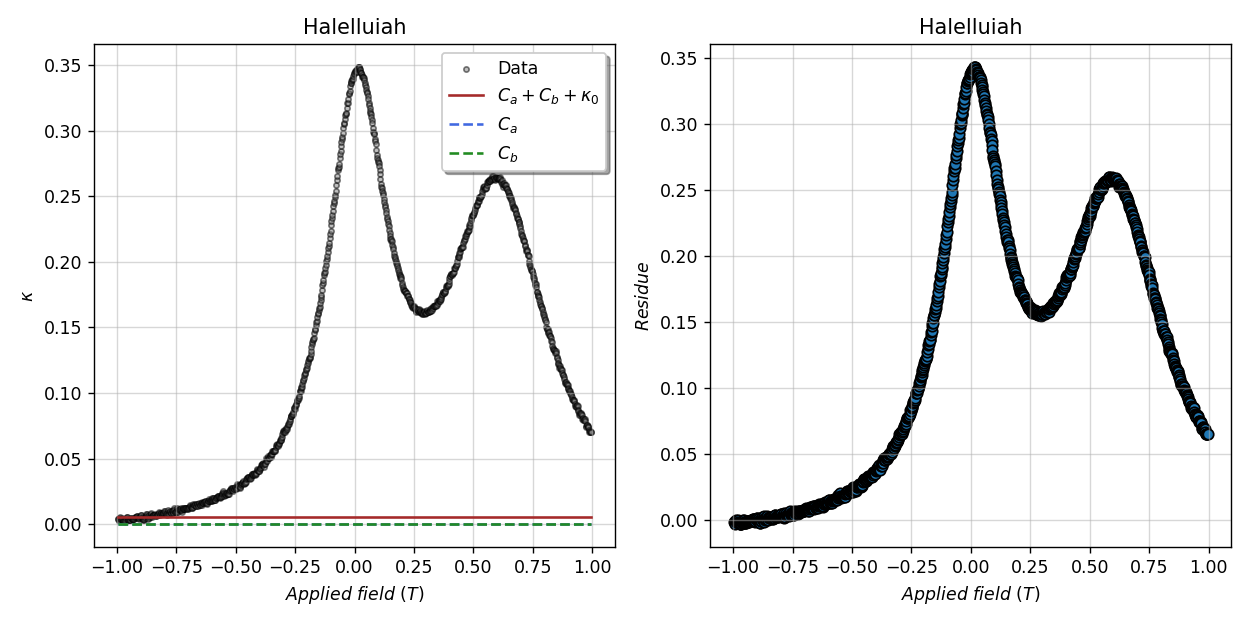

In [14]:
low_error=np.where(error_2==error_2.min())
low_error=int(low_error[0])

kick=parameterc_ac[:,low_error]

if Choice1=='1':
    
    error,p_0=Levenberg_Marquardt_1C(GGCD_1C,kick[0],kick[1],kick[2],
                                     kick[3],kick[4],xnew,grad_original-slope,constrain=constrain,sample_name=sample+'(final_inv)',eps=1e-15)
    
    inverted_model=GGCD_1C(p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],xnew)
    Ca_inverted=GGCD_1C(p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],xnew)

    resid=inverted_model-grad_original-slope
    figure,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

    ax1.scatter(xnew,grad_original,marker='.',edgecolor='k',color='gray',alpha=0.5,label='Data')
    ax1.plot(xnew,inverted_model+slope,color='brown',label='Inverted model')
    ax1.plot(xnew,Ca_inverted,label=r'$C_{a}$',color='royalblue',linestyle='dashed')
    ax1.set_xlabel(r'$Applied \ field \ (T)$')
    ax1.set_ylabel(r'$\kappa$')
    ax1.grid(alpha=0.5)
    ax1.set_title(f'{sample}')
    ax1.legend(shadow=True)
    ax1.grid(alpha=0.5)
    
    ax2.scatter(xnew,resid,edgecolor='k')
    ax2.set_xlabel(r'$Applied \ field \ (T)$')
    ax2.set_ylabel(r'$Residue $')
    ax2.grid(alpha=0.5)
    ax2.set_title(f'{sample}')
    ax2.grid(alpha=0.5)
    
    figure.tight_layout()
    plt.savefig('Final_inverted_model '+str(sample)+'.pdf',dpi=300,facecolor='w')

if Choice1=='2':
    
    error,p_0=Levenberg_Marquardt_2C(GGCD_2C,kick[0],kick[1],kick[2],
                                     kick[3],kick[4],kick[5],kick[6],
                                     kick[7],kick[8],kick[9],
                                     xnew,grad_original-slope,constrain=constrain,option=Option,sample_name=sample+'(final_inv)',eps=1e-15);
    
    inverted_model=GGCD_2C(p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],p_0[5],p_0[6],p_0[7],p_0[8],p_0[9],xnew)
    Ca_inverted=GGCD_1C(p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],xnew)
    Cb_inverted=GGCD_1C(p_0[5],p_0[6],p_0[7],p_0[8],p_0[9],xnew)
    
    resid=grad_original-(inverted_model+slope)
    figure,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

    ax1.scatter(xnew,grad_original,marker='.',edgecolor='k',color='gray',alpha=0.5,label='Data')
    ax1.plot(xnew,inverted_model+slope,label=r'$C_{a}+C_{b}+\kappa_{0}$',color='brown')
    ax1.plot(xnew,Ca_inverted,label=r'$C_{a}$',color='royalblue',linestyle='dashed')
    ax1.plot(xnew,Cb_inverted,label=r'$C_{b}$',color='forestgreen',linestyle='dashed')
    ax1.set_xlabel(r'$Applied \ field \ (T)$')
    ax1.set_ylabel(r'$\kappa$')
    ax1.grid(alpha=0.5)
    ax1.set_title(f'{sample}')
    ax1.legend(shadow=True)
    ax1.grid(alpha=0.5)
    
    ax2.scatter(xnew,resid,edgecolor='k')
    ax2.set_xlabel(r'$Applied \ field \ (T)$')
    ax2.set_ylabel(r'$Residue $')
    ax2.grid(alpha=0.5)
    ax2.set_title(f'{sample}')
    ax2.grid(alpha=0.5)
    
    figure.tight_layout()
    plt.savefig('Final_inverted_model '+str(sample)+'.pdf',dpi=300,facecolor='w')

if Choice1=='3':
    
    error,p_0=Levenberg_Marquardt_3C(GGCD_3C,kick[0],kick[1],kick[2],kick[3],kick[4],
                                     kick[5],kick[6],kick[7],kick[8],kick[9],kick[10],
                                     kick[11],kick[12],kick[13],kick[14],xnew,grad_original-slope,
                                     constrain=constrain,option=Option,sample_name=sample+'(final_inv)');
    
    inverted_model=GGCD_3C(p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],p_0[5],
                           p_0[6],p_0[7],p_0[8],p_0[9],p_0[10],
                           p_0[11],p_0[12],p_0[13],p_0[14],xnew)
    
    Ca_inverted=GGCD_1C(p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],xnew)
    Cb_inverted=GGCD_1C(p_0[5],p_0[6],p_0[7],p_0[8],p_0[9],xnew)
    Cc_inverted=GGCD_1C(p_0[10],p_0[11],p_0[12],p_0[13],p_0[14],xnew)

    resid=inverted_model-grad_original-slope
    figure,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))

    ax1.scatter(xnew,grad_original,marker='.',edgecolor='k',color='gray',alpha=0.5,label='Data')
    ax1.plot(xnew,inverted_model+slope,color='brown',label='Inverted model')
    ax1.plot(xnew,Ca_inverted,label=r'$C_{a}$',color='royalblue',linestyle='dashed')
    ax1.plot(xnew,Cb_inverted,label=r'$C_{b}$',color='forestgreen',linestyle='dashed')
    ax1.plot(xnew,Cc_inverted,label=r'$C_{c}$',color='m',linestyle='dashed')
    
    ax1.set_xlabel(r'$Applied \ field \ (T)$')
    ax1.set_ylabel(r'$\kappa$')
    ax1.grid(alpha=0.5)
    ax1.set_title(f'{sample}')
    ax1.legend(shadow=True)
    ax1.grid(alpha=0.5)
    
    ax2.scatter(xnew,resid,edgecolor='k')
    ax2.set_xlabel(r'$Applied \ field \ (T)$')
    ax2.set_ylabel(r'$e$')
    ax2.grid(alpha=0.5)
    ax2.set_title(f'{sample}')
    ax2.grid(alpha=0.5)
    
    figure.tight_layout()
    plt.savefig('Final_inverted_model '+str(sample)+'.pdf',dpi=300,facecolor='w')



<br>
&ensp;<b>D ↓</b> Plot the direct models using the optimized parameters obtained in the previous step and shows an hystogram distribution of their euclidian norms <b>‖e‖</b><sub>2</sub>
<br>
<br>

In [ ]:
def chi_squared(observed,calculated,parameter):
    chi=np.sum((observed-calculated)**2)/(np.size(observed)-np.size(p_0))
    
    return chi

chi2=chi_squared(grad_original,inverted_model+slope,p_0)

In [ ]:
inv=int(input('Define the number of models to be tested (must be an integer)! R: '))

if Choice1=='1':
    ranged=np.array([p_0[0],p_0[1],p_0[2],p_0[3],p_0[4]])
    variable_guesses=np.zeros((inv,np.size(ranged)))
    
    if constrain=='Y':
        for i in range(inv):
            for j in range(np.size(variable_guesses[1])):
                if j==0:
                    variable_guesses[i,j]=np.array(ranged[j])
                else:
                    variable_guesses[i,0]=np.array(ranged[0])
                    variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*chi2)))
                    variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*chi2)))
                    variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*chi2)))
                    variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*chi2)))
    if constrain=='N':
        for i in range(inv):
            for j in range(np.size(variable_guesses[1])):
                if j==0:
                    variable_guesses[i,j]=np.array(ranged[j])
                else:
                    variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*chi2)))
                    variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*chi2)))
                    variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*chi2)))
                    variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*chi2)))
                    variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*chi2)))


    error_2=np.zeros(inv)
    parameterc_ac=np.zeros((len(ranged),inv),dtype=np.longdouble)
    invertedmodels_ac=np.zeros((len(xnew),inv))
    for j in range(inv):
        error_2[j],parameterc_ac[:,j]=Levenberg_Marquardt_1C(GGCD_1C,variable_guesses[j,0],variable_guesses[j,1],variable_guesses[j,2],
                                                   variable_guesses[j,3],variable_guesses[j,4],xnew,grad_original-slope,constrain=constrain,sample_name=sample+'(second_inv)',maxiter=20);
        invertedmodels_ac[:,j]=GGCD_1C(parameterc_ac[0,j],parameterc_ac[1,j],parameterc_ac[2,j],parameterc_ac[3,j],
                                      parameterc_ac[4,j],xnew)

if Choice1=='2':
    ranged=np.array([p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],p_0[5],p_0[6],p_0[7],p_0[8],p_0[9]])
    variable_guesses=np.zeros((inv,np.size(ranged)))
    if constrain=='Y':
        if Option=='A':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:        
                        variable_guesses[i,0]=np.array(ranged[0])
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*chi2)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*chi2)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*chi2)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*chi2)))
                        variable_guesses[i,5]=np.array(ranged[5]+(np.random.normal()*abs(ranged[5]*chi2)))
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*chi2)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*chi2)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*chi2)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*chi2)))
        if Option=='B':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:        
                        variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*chi2)))
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*chi2)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*chi2)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*chi2)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*chi2)))
                        variable_guesses[i,5]=np.array(ranged[5])
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*chi2)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*chi2)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*chi2)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*chi2)))
        if Option=='C':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:        
                        variable_guesses[i,0]=np.array(ranged[0])
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*chi2)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*chi2)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*chi2)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*chi2)))
                        variable_guesses[i,5]=np.array(ranged[5])
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*chi2)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*chi2)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*chi2)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*chi2)))
    if constrain=='N':
        for i in range(inv):
            for j in range(np.size(variable_guesses[1])):
                if j==0:
                    variable_guesses[i,j]=np.array(ranged[j])
                else:
                    variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*chi2)))
                    variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*chi2)))
                    variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*chi2)))
                    variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*chi2)))
                    variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*chi2)))
                    variable_guesses[i,5]=np.array(ranged[5]+(np.random.normal()*abs(ranged[5]*chi2)))
                    variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*chi2)))
                    variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*chi2)))
                    variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*chi2)))
                    variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*chi2)))
                    
    invertedmodels_ac=np.zeros((len(xnew),inv))
    error_2=np.zeros(inv)
    parameterc_ac=np.zeros((len(ranged),inv),dtype=np.longdouble)

    for j in range(inv):
        error_2[j],parameterc_ac[:,j]=Levenberg_Marquardt_2C(GGCD_2C,variable_guesses[j,0],variable_guesses[j,1],variable_guesses[j,2],
                                                             variable_guesses[j,3],variable_guesses[j,4],variable_guesses[j,5],
                                                             variable_guesses[j,6],variable_guesses[j,7],variable_guesses[j,8],
                                                             variable_guesses[j,9],xnew,grad_original-slope,
                                                             constrain=constrain,option=Option,sample_name=sample,maxiter=20);
        invertedmodels_ac[:,j]=GGCD_2C(parameterc_ac[0,j],parameterc_ac[1,j],parameterc_ac[2,j],parameterc_ac[3,j],
                                       parameterc_ac[4,j],parameterc_ac[5,j],parameterc_ac[6,j],parameterc_ac[7,j],
                                       parameterc_ac[8,j],parameterc_ac[9,j],xnew)

if Choice1=='3':
    ranged=np.array([p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],p_0[5],
                     p_0[6],p_0[7],p_0[8],p_0[9],p_0[10],
                     p_0[11],p_0[12],p_0[13],p_0[14]])
    variable_guesses=np.zeros((inv,np.size(ranged)))
    
    if constrain=='Y':
        if Option=='A':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:
                        variable_guesses[i,0]=np.array(ranged[0])
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*chi2)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*chi2)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*chi2)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*chi2)))
                        variable_guesses[i,5]=np.array(ranged[5]+(np.random.normal()*abs(ranged[5]*chi2)))
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*chi2)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*chi2)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*chi2)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*chi2)))
                        variable_guesses[i,10]=np.array(ranged[10]+(np.random.normal()*abs(ranged[10]*chi2)))
                        variable_guesses[i,11]=np.array(ranged[11]+(np.random.normal()*abs(ranged[11]*chi2)))
                        variable_guesses[i,12]=np.array(ranged[12]+(np.random.normal()*abs(ranged[12]*chi2)))
                        variable_guesses[i,13]=np.array(ranged[13]+(np.random.normal()*abs(ranged[13]*chi2)))
                        variable_guesses[i,14]=np.array(ranged[14]+(np.random.normal()*abs(ranged[14]*chi2)))
        if Option=='B':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:
                        variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*chi2)))
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*chi2)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*chi2)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*chi2)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*chi2)))
                        variable_guesses[i,5]=np.array(ranged[5])
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*chi2)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*chi2)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*chi2)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*chi2)))
                        variable_guesses[i,10]=np.array(ranged[10]+(np.random.normal()*abs(ranged[10]*chi2)))
                        variable_guesses[i,11]=np.array(ranged[11]+(np.random.normal()*abs(ranged[11]*chi2)))
                        variable_guesses[i,12]=np.array(ranged[12]+(np.random.normal()*abs(ranged[12]*chi2)))
                        variable_guesses[i,13]=np.array(ranged[13]+(np.random.normal()*abs(ranged[13]*chi2)))
                        variable_guesses[i,14]=np.array(ranged[14]+(np.random.normal()*abs(ranged[14]*chi2)))
        if Option=='C':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:
                        variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*chi2)))
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*chi2)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*chi2)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*chi2)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*chi2)))
                        variable_guesses[i,5]=np.array(ranged[5]+(np.random.normal()*abs(ranged[5]*chi2)))
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*chi2)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*chi2)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*chi2)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*chi2)))
                        variable_guesses[i,10]=np.array(ranged[10])
                        variable_guesses[i,11]=np.array(ranged[11]+(np.random.normal()*abs(ranged[11]*chi2)))
                        variable_guesses[i,12]=np.array(ranged[12]+(np.random.normal()*abs(ranged[12]*chi2)))
                        variable_guesses[i,13]=np.array(ranged[13]+(np.random.normal()*abs(ranged[13]*chi2)))
                        variable_guesses[i,14]=np.array(ranged[14]+(np.random.normal()*abs(ranged[14]*chi2)))
        if Option=='D':
            for i in range(inv):
                for j in range(np.size(variable_guesses[1])):
                    if j==0:
                        variable_guesses[i,j]=np.array(ranged[j])
                    else:
                        variable_guesses[i,0]=np.array(ranged[0])
                        variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*chi2)))
                        variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*chi2)))
                        variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*chi2)))
                        variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*chi2)))
                        variable_guesses[i,5]=np.array(ranged[5])
                        variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*chi2)))
                        variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*chi2)))
                        variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*chi2)))
                        variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*chi2)))
                        variable_guesses[i,10]=np.array(ranged[10])
                        variable_guesses[i,11]=np.array(ranged[11]+(np.random.normal()*abs(ranged[11]*chi2)))
                        variable_guesses[i,12]=np.array(ranged[12]+(np.random.normal()*abs(ranged[12]*chi2)))
                        variable_guesses[i,13]=np.array(ranged[13]+(np.random.normal()*abs(ranged[13]*chi2)))
                        variable_guesses[i,14]=np.array(ranged[14]+(np.random.normal()*abs(ranged[14]*chi2)))
                    
    if constrain=='N':
        for i in range(inv):
            for j in range(np.size(variable_guesses[1])):
                if j==0:
                    variable_guesses[i,j]=np.array(ranged[j])
                else:
                    variable_guesses[i,0]=np.array(ranged[0]+(np.random.normal()*abs(ranged[0]*chi2)))
                    variable_guesses[i,1]=np.array(ranged[1]+(np.random.normal()*abs(ranged[1]*chi2)))
                    variable_guesses[i,2]=np.array(ranged[2]+(np.random.normal()*abs(ranged[2]*chi2)))
                    variable_guesses[i,3]=np.array(ranged[3]+(np.random.normal()*abs(ranged[3]*chi2)))
                    variable_guesses[i,4]=np.array(ranged[4]+(np.random.normal()*abs(ranged[4]*chi2)))
                    variable_guesses[i,5]=np.array(ranged[5]+(np.random.normal()*abs(ranged[5]*chi2)))
                    variable_guesses[i,6]=np.array(ranged[6]+(np.random.normal()*abs(ranged[6]*chi2)))
                    variable_guesses[i,7]=np.array(ranged[7]+(np.random.normal()*abs(ranged[7]*chi2)))
                    variable_guesses[i,8]=np.array(ranged[8]+(np.random.normal()*abs(ranged[8]*chi2)))
                    variable_guesses[i,9]=np.array(ranged[9]+(np.random.normal()*abs(ranged[9]*chi2)))
                    variable_guesses[i,10]=np.array(ranged[10]+(np.random.normal()*abs(ranged[10]*chi2)))
                    variable_guesses[i,11]=np.array(ranged[11]+(np.random.normal()*abs(ranged[11]*chi2)))
                    variable_guesses[i,12]=np.array(ranged[12]+(np.random.normal()*abs(ranged[12]*chi2)))
                    variable_guesses[i,13]=np.array(ranged[13]+(np.random.normal()*abs(ranged[13]*chi2)))
                    variable_guesses[i,14]=np.array(ranged[14]+(np.random.normal()*abs(ranged[14]*chi2)))


    invertedmodels_ac=np.zeros((len(xnew),inv))
    error_2=np.zeros(inv)
    parameterc_ac=np.zeros((len(ranged),inv),dtype=np.longdouble)
    for j in range(inv):
        error_2[j],parameterc_ac[:,j]=Levenberg_Marquardt_3C(GGCD_3C,variable_guesses[j,0],variable_guesses[j,1],variable_guesses[j,2],
                                                             variable_guesses[j,3],variable_guesses[j,4],variable_guesses[j,5],
                                                             variable_guesses[j,6],variable_guesses[j,7],variable_guesses[j,8],
                                                             variable_guesses[j,9],variable_guesses[j,10],variable_guesses[j,11],
                                                             variable_guesses[j,12],variable_guesses[j,13],variable_guesses[j,14],
                                                             xnew,grad_original-slope,constrain=constrain,option=Option,
                                                             sample_name=sample,maxiter=20);
        invertedmodels_ac[:,j]=GGCD_3C(parameterc_ac[0,j],parameterc_ac[1,j],parameterc_ac[2,j],parameterc_ac[3,j],
                                       parameterc_ac[4,j],parameterc_ac[5,j],parameterc_ac[6,j],parameterc_ac[7,j],
                                       parameterc_ac[8,j],parameterc_ac[9,j],parameterc_ac[10,j],parameterc_ac[11,j],
                                       parameterc_ac[12,j],parameterc_ac[13,j],parameterc_ac[14,j],xnew)






<br>
&ensp;<b>F ↓</b> Calculate the 95% confidence intervals for model parameters from the <b>Monte Carlo erro propagation</b>. Sequentially, apply a simple <b>Two-tailed F-test</b> to verify if the variance of the final model can be distinguished from the variance of the data at 95% of confidence.
<br>
<br>

In [ ]:
A=np.zeros((np.shape(parameterc_ac)[0],inv))

p_copied=np.copy(p_0)
p_copied=np.reshape(p_copied,(np.size(p_0),1))


for i in range(np.shape(parameterc_ac)[1]):
     A[:,i]=parameterc_ac[:,i]-p_copied[:,0]


A_averaged=[]

for i in range(np.size(p_copied)):
    A_averaged=np.append(A_averaged,np.average(A[i,:]))


A_averaged=np.reshape(A_averaged,(1,np.size(p_copied)))


COV=(A_averaged.T@A_averaged)/np.size(p_copied)

diag_COV=np.diag(COV)

a95=1.96*(diag_COV**(1/2))

F_stat=np.var(grad_original,ddof=1)/np.var(inverted_model+slope,ddof=1)
df=np.size(grad_original)-1

#find F critical value
critical_f=scipy.stats.f.ppf(q=1-(0.05/2), dfn=df, dfd=df)

if critical_f>F_stat:
    print('Calculated F-value:',F_stat)
    print('Critical F-value:',critical_f)
    print('The variances of the inversion and the data are indistinguishable  using the two-tailed F-test')
if critical_f<F_stat:
    print('Calculated F-value:',F_stat)
    print('Critical F-value:',critical_f)
    print('The variances of the inversion and the data are distinguishable  using the two-tailed F-test')


final_delta_d=(grad_original-(inverted_model+slope))
euclidean_norm=np.linalg.norm(final_delta_d**2,2)

print('')

R2=R2_calc(grad_original,(inverted_model+slope))

print('R² is: ',np.round(R2,4))
print('||e²|| is:', "{:e}".format(euclidean_norm))

df=pd.DataFrame(data={'Uncertainties':a95})

df.to_csv('uncertainties_parameters_'+str(sample)+'.csv', index=False)

figure,(ax4,ax5)=plt.subplots(1,2,figsize=(10,5))
ax4.plot(xnew,invertedmodels_ac+slope,alpha=0.2)
ax4.scatter(xnew,grad_original,marker='.',color='gray',edgecolor='k',label='Data',zorder=20)
ax4.set_xlabel(r'$B \ (T)$')
ax4.set_ylabel(r'$\kappa / \kappa_{(max)}$')
ax4.legend(shadow=True)
ax4.grid(alpha=0.5)
ax5=sns.histplot(error_2,kde=True,palette=['royalblue'])
ax5.set_xlabel(f'$||e²||_{{[2]}}$')
ax5.set_ylabel('Counts')
ax5.grid(alpha=0.5)
figure.tight_layout()
plt.savefig('Monte_carlo_simulations '+str(sample)+'.pdf',dpi=300,facecolor='w')



<br>
&ensp;<b>G ↓</b> Calculate magnetization saturation <b><i>(Ms)</b></i> and magnetization saturation of remanence <i><b>(Mrs)</b></i> through the inverted parameters.
<br>
<br>

In [ ]:
if Choice1=='1':
    Ca=GGCD_1C(p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],xnew)
    f = interpolate.interp1d(xnew,Ca,kind='cubic')
    x2 = np.linspace(xnew[0],xnew[-1],200000)
    y2 = f(x2)
    x3=[]
    y3=[]
    
    for i in range(np.size(x2)):
        if x2[i]>p_0[0]:
            x3=np.append(x3,x2[i])
            y3=np.append(y3,y2[i])


    x4=[]
    y4=[]

    for i in range(np.size(x2)):
        if x2[i]>0 and x2[i]<p_0[0]:
            x4=np.append(x4,x2[i])
            y4=np.append(y4,y2[i])        


    Ms_Ca=simpson(y3,x3, dx=1e-15)
    Mrs_Ca=simpson(y4,x4,dx=1e-15)
    
    print(r'First component Ms is:',Ms_Ca)
    print(r'First component Mrs is:',Mrs_Ca)
    
if Choice1=='2':
    Ca=GGCD_2C(p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],p_0[5],p_0[6],p_0[7],p_0[8],0,xnew)
    Cb=GGCD_2C(p_0[0],p_0[1],p_0[2],p_0[3],0,p_0[5],p_0[6],p_0[7],p_0[8],p_0[9],xnew)
    
    fa = interpolate.interp1d(xnew,Ca,kind='cubic')
    fb = interpolate.interp1d(xnew,Cb,kind='cubic')
    
    x2 = np.linspace(xnew[0],xnew[-1],200000) 
    ya = fa(x2)
    yb = fb(x2)
    
    xa1=[]
    xb1=[]
    ya1=[]
    yb1=[]
    
    for i in range(np.size(x2)):
        if x2[i]>p_0[0]:
            xa1=np.append(xa1,x2[i])
            ya1=np.append(ya1,ya[i])
        if x2[i]>p_0[5]:
            xb1=np.append(xb1,x2[i])
            yb1=np.append(yb1,yb[i])


    xa2=[]
    xb2=[]
    ya2=[]
    yb2=[]

    for i in range(np.size(x2)):
        if x2[i]>0 and x2[i]<p_0[0]:
            xa2=np.append(xa2,x2[i])
            ya2=np.append(ya2,ya[i])
        if x2[i]>0 and x2[i]<p_0[5]:
            xb2=np.append(xb2,x2[i])
            yb2=np.append(yb2,yb[i])

    Ms_Ca=simpson(ya1,xa1,dx=1e-15)
    Mrs_Ca=simpson(ya2,xa2,dx=1e-15)
    
    Ms_Cb=simpson(yb1,xb1,dx=1e-15)
    Mrs_Cb=simpson(yb2,xb2,dx=1e-15)
    
    print(r'First component Ms is:',Ms_Ca)
    print(r'First component Mrs is:',Mrs_Ca)
    print('')
    print(r'Second component Ms is:',Ms_Cb)
    print(r'Second component Mrs is:',Mrs_Cb)

    
if Choice1=='3':
    Ca=GGCD_3C(p_0[0],p_0[1],p_0[2],p_0[3],p_0[4],p_0[5],
               p_0[6],p_0[7],p_0[8],0,p_0[10],
               p_0[11],p_0[12],p_0[13],0,xnew)
    Cb=GGCD_3C(p_0[0],p_0[1],p_0[2],p_0[3],0,p_0[5],
               p_0[6],p_0[7],p_0[8],p_0[9],p_0[10],
               p_0[11],p_0[12],p_0[13],0,xnew)
    Cc=GGCD_3C(p_0[0],p_0[1],p_0[2],p_0[3],0,p_0[5],
               p_0[6],p_0[7],p_0[8],0,p_0[10],
               p_0[11],p_0[12],p_0[13],p_0[14],xnew)
    
    fa = interpolate.interp1d(xnew,Ca,kind='cubic')
    fb = interpolate.interp1d(xnew,Cb,kind='cubic')
    fc = interpolate.interp1d(xnew,Cc,kind='cubic')
    
    x2 = np.linspace(xnew[0],xnew[-1],200000) 
    ya = fa(x2)
    yb = fb(x2)
    yc = fc(x2)
    
    xa1=[]
    xb1=[]
    xc1=[]
    ya1=[]
    yb1=[]
    yc1=[]
    
    for i in range(np.size(x2)):
        if x2[i]>p_0[0]:
            xa1=np.append(xa1,x2[i])
            ya1=np.append(ya1,ya[i])
        if x2[i]>p_0[5]:
            xb1=np.append(xb1,x2[i])
            yb1=np.append(yb1,yb[i])
        if x2[i]>p_0[10]:
            xc1=np.append(xc1,x2[i])
            yc1=np.append(yc1,yc[i])



    xa2=[]
    xb2=[]
    xc2=[]
    ya2=[]
    yb2=[]
    yc2=[]

    for i in range(np.size(x2)):
        if x2[i]>0 and x2[i]<p_0[0]:
            xa2=np.append(xa2,x2[i])
            ya2=np.append(ya2,ya[i])
        if x2[i]>0 and x2[i]<p_0[5]:
            xb2=np.append(xb2,x2[i])
            yb2=np.append(yb2,yb[i])
        if x2[i]>0 and x2[i]<p_0[10]:
            xc2=np.append(xc2,x2[i])
            yc2=np.append(yc2,yc[i])


    Ms_Ca=simpson(ya1,xa1,dx=1e-15)
    Mrs_Ca=simpson(ya2,xa2,dx=1e-15)
    
    Ms_Cb=simpson(yb1,xb1,dx=1e-15)
    Mrs_Cb=simpson(yb2,xb2,dx=1e-15)
    
    Ms_Cc=simpson(yc1,xc1,dx=1e-15)
    Mrs_Cc=simpson(yc2,xc2,dx=1e-15)
    
    print(r'First component Ms is:',Ms_Ca)
    print(r'First component Mrs is:',Mrs_Ca)
    print('')
    print(r'Second component Ms is:',Ms_Cb)
    print(r'Second component Mrs is:',Mrs_Cb)
    print('')
    print(r'Third component Ms is:',Ms_Cc)
    print(r'Third component Mrs is:',Mrs_Cc)


In [ ]:
str1,str2,str3='a','b','c'

if Choice1=='1':
    xx,yA=[],[]
    for i in range(np.size(xnew)):
        if xnew[i]>=0.8 and xnew[i]<=1.0:
            xx=np.append(xx,xnew[i])
            yA=np.append(yA,Ca[i])
            

    error_hf1,parameters_hf1=Levenberg_Marquardt_HF(high_field,-1,-1,xx,yA/max(yA),eps=1e-15)
    high_field_inv1=high_field(parameters_hf1[0]*max(yA),parameters_hf1[1],xx)
    R2_hf_Ca=R2_calc(yA,high_field_inv1)
    
    if parameters_hf1[1]<0:
        Ms_Ca=Ms_Ca
    if parameters_hf1[1]>0:
        Ms_Ca=Ms_Ca+(parameters_hf1[0]*(7**parameters_hf1[1]))
        
    print(r'First component λ is:',parameters_hf1[0])
    print(r'First component Φ is:',parameters_hf1[1])
    
    figure, ax=plt.subplots(figsize=(5,5))

    ax.scatter(xx,yA/max(yA),marker='o',edgecolor='k',color='royalblue',label='$C_{a}$')
    ax.plot(xx,high_field_inv1/max(high_field_inv1),label=f'$Cinv_{str1},R^{2}:{np.round(R2_hf_Ca,7)}$',color='k')
    ax.grid(alpha=0.5)
    ax.legend(shadow=True,fontsize=9)
    ax.set_xlabel('Applied field (T)')
    ax.set_ylabel('$\kappa_{hf} / \kappa_{MAX \ hf} $')
    ax.legend(shadow=True,fontsize=6)
    plt.savefig('high_field_saturation_adjust.pdf',dpi=300,facecolor='w')


if Choice1=='2':
    xx,yA,yB=[],[],[]
    for i in range(np.size(xnew)):
        if xnew[i]>=0.8 and xnew[i]<=1.0:
            xx=np.append(xx,xnew[i])
            yA=np.append(yA,Ca[i])
            yB=np.append(yB,Cb[i])
            

    error_hf1,parameters_hf1=Levenberg_Marquardt_HF(high_field,-0.5,-2,xx,yA/max(yA),eps=1e-15)
    high_field_inv1=high_field(parameters_hf1[0]*max(yA),parameters_hf1[1],xx)
    
    error_hf2,parameters_hf2=Levenberg_Marquardt_HF(high_field,-0.5,-2,xx,yB/max(yB),eps=1e-15)
    high_field_inv2=high_field(parameters_hf2[0]*max(yB),parameters_hf2[1],xx)
    
    R2_hf_Ca=R2_calc(yA,high_field_inv1)
    R2_hf_Cb=R2_calc(yB,high_field_inv2)  
    
    if parameters_hf1[1]<0:
        Ms_Ca=Ms_Ca
    if parameters_hf1[1]>0:
        Ms_Ca=Ms_Ca+(parameters_hf1[0]*(7**parameters_hf1[1]))
        
    if parameters_hf2[1]<0:
        Ms_Cb=Ms_Cb
    if parameters_hf2[1]>0:
        Ms_Cb=Ms_Cb+(parameters_hf2[0]*(7**parameters_hf2[1]))
        
    print(r'First component λ is:',parameters_hf1[0])
    print(r'First component Φ is:',parameters_hf1[1])
    print('')
    print(r'Second component λ is:',parameters_hf2[0])
    print(r'Second component Φ is:',parameters_hf2[1])

    figure, ax=plt.subplots(figsize=(5,5))

    ax.scatter(xx,yA/max(yA),marker='o',edgecolor='k',color='royalblue',label='$C_{a}$')
    ax.plot(xx,high_field_inv1/max(high_field_inv1),label=f'$Cinv_{str1},R^{2}:{np.round(R2_hf_Ca,7)}$',color='k')
    ax.scatter(xx,yB/max(yB),marker='o',edgecolor='k',color='forestgreen',label='$C_{b}$')
    ax.plot(xx,high_field_inv2/max(high_field_inv2),label=f'$Cinv_{str2},R^{2}:{np.round(R2_hf_Cb,7)}$',color='r')
    ax.grid(alpha=0.5)
    ax.set_xlabel('Applied field (T)')
    ax.set_ylabel('$\kappa_{hf} / \kappa_{MAX \ hf} $')
    ax.legend(shadow=True,fontsize=6)
    plt.savefig('high_field_saturation_adjust.pdf',dpi=300,facecolor='w')


if Choice1=='3':
    xx,yA,yB,yC=[],[],[],[]
    for i in range(np.size(xnew)):
        if xnew[i]>=0.8 and xnew[i]<=1.0:
            xx=np.append(xx,xnew[i])
            yA=np.append(yA,Ca[i])
            yB=np.append(yB,Cb[i])
            yC=np.append(yC,Cc[i])
            

    error_hf1,parameters_hf1=Levenberg_Marquardt_HF(high_field,-1,-1,xx,yA/max(yA),eps=1e-15)
    high_field_inv1=high_field(parameters_hf1[0]*max(yA),parameters_hf1[1],xx)
    
    error_hf2,parameters_hf2=Levenberg_Marquardt_HF(high_field,-0.5,-2,xx,yB/max(yB),eps=1e-15)
    high_field_inv2=high_field(parameters_hf2[0]*max(yB),parameters_hf2[1],xx)
    
    error_hf3,parameters_hf3=Levenberg_Marquardt_HF(high_field,-0.5,-2,xx,yC/max(yC),eps=1e-15)
    high_field_inv3=high_field(parameters_hf3[0]*max(yC),parameters_hf3[1],xx)
    
    R2_hf_Ca=R2_calc(yA,high_field_inv1)
    R2_hf_Cb=R2_calc(yB,high_field_inv2)
    R2_hf_Cc=R2_calc(yC,high_field_inv3)
    
    if parameters_hf1[1]<0:
        Ms_Ca=Ms_Ca
    if parameters_hf1[1]>0:
        Ms_Ca=Ms_Ca+(parameters_hf1[0]*(7**parameters_hf1[1]))
        
    if parameters_hf2[1]<0:
        Ms_Cb=Ms_Cb
    if parameters_hf2[1]>0:
        Ms_Cb=Ms_Cb+(parameters_hf2[0]*(7**parameters_hf2[1]))
        
    if parameters_hf3[1]<0:
        Ms_Cc=Ms_Cc
    if parameters_hf3[1]>0:
        Ms_Cc=Ms_Cc+(parameters_hf3[0]*(7**parameters_hf3[1]))

    print(r'First component λ is:',parameters_hf1[0])
    print(r'First component Φ is:',parameters_hf1[1])
    print('')
    print(r'Second component λ is:',parameters_hf2[0])
    print(r'Second component Φ is:',parameters_hf2[1])
    print('')
    print(r'Third component λ is:',parameters_hf3[0])
    print(r'Third component Φ is:',parameters_hf3[1])
    
    figure, ax=plt.subplots(figsize=(5,5))

    ax.scatter(xx,yA/max(yA),marker='o',edgecolor='k',color='royalblue',label='$C_{a}$')
    ax.plot(xx,high_field_inv1/max(high_field_inv1),label=f'$Cinv_{str1},R^{2}:{np.round(R2_hf_Ca,7)}$',color='k')
    ax.scatter(xx,yB/max(yB),marker='o',edgecolor='k',color='forestgreen',label='$C_{b}$')
    ax.plot(xx,high_field_inv2/max(high_field_inv2),label=f'$Cinv_{str2},R^{2}:{np.round(R2_hf_Cb,7)}$',color='r')
    ax.scatter(xx,yC/max(yC),marker='o',edgecolor='k',color='m',label='$C_{c}$')
    ax.plot(xx,high_field_inv3/max(high_field_inv3),label=f'$Cinv_{str3},R^{2}:{np.round(R2_hf_Cc,7)}$',color='y')
    ax.grid(alpha=0.5)
    ax.legend(shadow=True,fontsize=6)
    ax.set_xlabel('Applied field (T)')
    ax.set_ylabel('$\kappa_{hf} / \kappa_{MAX \ hf} $')
    plt.savefig('high_field_saturation_adjust.pdf',dpi=300,facecolor='w')


<br>
&ensp;<b>H ↓</b> Generate tables to display modeling parameters.
<br>
<br>

In [ ]:
if Choice1=='1':
    fig1 = go.Figure(data=[go.Table(header=dict(values=['Parameters','Ca']),
                     cells=dict(values=[['$\mu \ (T)$', '$θ$','$α$','$β$','$I$','$Ms$','$Mrs$'],
                                        ["{:e}".format(p_0[0]),"{:e}".format(p_0[1]),"{:e}".format(p_0[2]),"{:e}".format(p_0[3]),"{:e}".format(p_0[4]),"{:e}".format(Ms_Ca),"{:e}".format(Mrs_Ca)]]))
                         ])
    fig1.update_layout(width=1000, height=400)
    fig1.show()
    
    
    fig3 = go.Figure(data=[go.Table(header=dict(values=['Parameters','Values']),
                     cells=dict(values=[['$\kappa_{0}$', '$\kappa_{ferro}$', '$||e²||_{2}$','$R²$', 'Calculated F-value (95%)','Critical F-value (95%)'],
                                        ["{:e}".format(slope),"{:e}".format(Ms_Ca),"{:e}".format(euclidean_norm),np.round(R2,4),np.round(F_stat,4),np.round(critical_f,4)]]))
                         ])
    fig3.update_layout(width=1000, height=400)
    fig3.show()


if Choice1=='2':
    fig1 = go.Figure(data=[go.Table(header=dict(values=['Parameters','Ca', 'Cb']),
                     cells=dict(values=[['$\mu \ (T)$', '$θ$','$α$','$β$','$I$','$Ms$','$Mrs$'],
                                        ["{:e}".format(p_0[0]),"{:e}".format(p_0[1]),"{:e}".format(p_0[2]),"{:e}".format(p_0[3]),"{:e}".format(p_0[4]),"{:e}".format(Ms_Ca),"{:e}".format(Mrs_Ca)],
                                       ["{:e}".format(p_0[5]),"{:e}".format(p_0[6]),"{:e}".format(p_0[7]),"{:e}".format(p_0[8]),"{:e}".format(p_0[9]),"{:e}".format(Ms_Cb),"{:e}".format(Mrs_Cb)]]))
                         ])
    fig1.update_layout(width=1000, height=400)
    fig1.show()
    
    
    fig3 = go.Figure(data=[go.Table(header=dict(values=['Parameters','Values']),
                     cells=dict(values=[['$\kappa_{0}$', '$\kappa_{ferro}$', '$||e²||_{2}$','$R²$','Calculated F-value (95%)','Critical F-value (95%)'],
                                        ["{:e}".format(slope),"{:e}".format(Ms_Ca+Ms_Cb),"{:e}".format(euclidean_norm),np.round(R2,4),np.round(F_stat,4),np.round(critical_f,4)]]))
                         ])
    fig3.update_layout(width=1000, height=400)
    fig3.show()
    
if Choice1=='3':
    fig1 = go.Figure(data=[go.Table(header=dict(values=['Parameters','Ca', 'Cb','Cc']),
                     cells=dict(values=[['$\mu \ (T)$', '$θ$','$α$','$β$','$I$','$Ms$','$Mrs$'],
                                        ["{:e}".format(p_0[0]),"{:e}".format(p_0[1]),"{:e}".format(p_0[2]),"{:e}".format(p_0[3]),"{:e}".format(p_0[4]),"{:e}".format(Ms_Ca),"{:e}".format(Mrs_Ca)],
                                       ["{:e}".format(p_0[5]),"{:e}".format(p_0[6]),"{:e}".format(p_0[7]),"{:e}".format(p_0[8]),"{:e}".format(p_0[9]),"{:e}".format(Ms_Cb),"{:e}".format(Mrs_Cb)],
                                       ["{:e}".format(p_0[10]),"{:e}".format(p_0[11]),"{:e}".format(p_0[12]),"{:e}".format(p_0[13]),"{:e}".format(p_0[14]),"{:e}".format(Ms_Cc),"{:e}".format(Mrs_Cc)]]))
                         ])
    fig1.update_layout(width=1000, height=400)
    fig1.show()
    
    
    fig3 = go.Figure(data=[go.Table(header=dict(values=['Parameters','Values']),
                     cells=dict(values=[['$\kappa_{0}$', '$\kappa_{ferro}$', '$||e²||_{2}$','$R²$','Calculated F-value (95%)','Critical F-value (95%)'],
                                        ["{:e}".format(slope),"{:e}".format(Ms_Ca+Ms_Cb+Ms_Cc),"{:e}".format(euclidean_norm),np.round(R2,4),np.round(F_stat,4),np.round(critical_f,4)]]))
                         ])
    fig3.update_layout(width=1000, height=400)
    fig3.show()

<br>
<br>
<br>
<hr>
<center><b><big> ACKNOWLEDGEMENTS </center></b></big>
<hr>
<br>
<hr>
&ensp;We would like to thank the creators and collaborators of the python libraries used in this package:
<br>
<br>
<br>
<center>&ensp;Numpy <b>[1]</b>, Matplotlib <b>[2]</b>, Scipy <b>[3]</b>, Pandas <b>[4]</b>, Seaborn <b>[5]</b>, Plotly <b>[6]</b></center>
<br>
<br>

   
&ensp;&ensp;<b>[1]</b> Harris, C.R., and others. Array programming with NumPy. <i>Nature</i> 585, 357–362 (2020). DOI: 10.1038/s41586-020-2649-2.

&ensp;&ensp;<b>[2]</b> J. D. Hunter, "Matplotlib: A 2D Graphics Environment", <i>Computing in Science & Engineering</i>, vol. 9, no. 3, pp. 90-95, 2007. DOI: 10.5281/zenodo.592536.

&ensp;&ensp;<b>[3]</b> Virtanen, P., and others (2020) SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. <i>Nature Methods</i>, 17(3), 261-272. DOI: 10.1038/s41592-019-0686-2.

&ensp;&ensp;<b>[4]</b> McKinney, W., and others. (2010). Data structures for statistical computing in python. In: <i>Proceedings of the 9th Python in Science Conference</i> (Vol. 445, pp. 51–56).

&ensp;&ensp;<b>[5]</b> Waskom, M., and others (2017). mwaskom/seaborn: v0.8.1 (September 2017). Zenodo. DOI: 10.5281/zenodo.883859

&ensp;&ensp;<b>[6]</b> Inc., P. T. (2015). Collaborative data science. Montreal, QC: Plotly Technologies Inc. Retrieved from https://plot.ly.

<hr>